# Decision trees and NN tryouts on SPR data

In [69]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import os
import numpy as np
import pandas as pd

import logging
logging.getLogger().handlers = []
logging.basicConfig(level=logging.INFO)

import matplotlib.pylab as plt
%matplotlib inline

In [95]:
import sys
sys.path.append("../common")

from dataset2 import load_trainval
from dataset2 import FEATURES_NAMES, TARGET_GROUP_DEC_LABELS, TARGET_LABELS_FRQ, ADDED_TARGET_LABELS, LAST_TARGET_LABELS
from dataset2 import PROCESSED_TARGETS, TARGET_GROUPS_DEC, TARGET_GROUPS, DIFF_TARGETS
from utils import to_yearmonth, TARGET_LABELS, TARGET_LABELS2
from utils import target_str_to_labels, decimal_to_dummies, targets_str_to_indices, targets_dec_to_indices

In [186]:
X, Y = load_trainval(201605, 250000)

INFO:root:- Load file : ../data/train_ver2.csv, yearmonth=201605, n_clients=250000
INFO:root:-- Select 250000 clients
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:- Add a supplementary data : 201603
INFO:root:-- Select max clients
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:-- Compute missing clients : 1216/250000
INFO:root:--- Setup them with zero targets
INFO:root:- Add a supplementary data : 201601
INFO:root:-- Select max clients
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:-- Compute missing clients : 4288/250000
INFO:root:--- Setup them with zero targets
INFO:root:- Add a supplementary data : 201505
INFO:root:-- Select max clients
INFO:root:- Number of lines with unknown data : 3597
INFO:root:- Number of columns with nan : 10
INFO:root:-- Compute missing clients : 82539/250000
INFO:root:--- Setup them with

In [187]:
print X.shape, Y.shape

(250000, 157) (250000, 76)


In [188]:
set(X.columns) - \
set(FEATURES_NAMES + 
    PROCESSED_TARGETS(1) + 
    PROCESSED_TARGETS(2) + 
    PROCESSED_TARGETS(3) + 
    PROCESSED_TARGETS(4) + 
    DIFF_TARGETS(1, 2) + 
    DIFF_TARGETS(1, 3) + 
    DIFF_TARGETS(1, 4) 
   )

{'fecha_alta', 'fecha_dato', 'ncodpers'}

In [189]:
set(Y.columns) - set(TARGET_LABELS + LAST_TARGET_LABELS.tolist() + ADDED_TARGET_LABELS.tolist())

{'added_targets_dec', 'added_targets_str', 'last_targets_str', 'targets_str'}

In [190]:
X.isnull().any().all(), Y.isnull().any().all()

(False, False)

In [191]:
DIFF_TARGETS(1, 2)

['diff_targets_dec_12',
 'diff_targets_dec_g0_12',
 'diff_targets_dec_g1_12',
 'diff_targets_dec_g2_12',
 'diff_targets_dec_g3_12']

In [192]:
Y['added_targets_dec'].unique()

array([0, 1, 3, 2, 4, 5])

In [193]:
FEATURES_NAMES

[u'ind_empleado',
 u'pais_residencia',
 u'sexo',
 u'age',
 u'ind_nuevo',
 u'antiguedad',
 u'indrel',
 u'ult_fec_cli_1t',
 u'indrel_1mes',
 u'tiprel_1mes',
 u'indresi',
 u'indext',
 u'conyuemp',
 u'canal_entrada',
 u'indfall',
 u'nomprov',
 u'ind_actividad_cliente',
 u'renta',
 u'segmento']

In [195]:
X[['ncodpers', 'targets_str_1', 'targets_str_2', 'diff_targets_dec_12', 'targets_logdec_1', 'targets_logdec_2']].head(10)

,ncodpers,targets_str_1,targets_str_2,diff_targets_dec_12,targets_logdec_1,targets_logdec_2
310484,15893,000000000000000000010000,000000000000000000010000,0,2.833213,2.833213
310472,15907,001000010000010101110001,001000010000010101110001,0,14.587507,14.587507
310468,15913,001000000000000100110001,001000000000000100110001,0,14.556237,14.556237
310466,15915,000000000000000000000000,000000000000000000000000,0,0.000000,0.000000
310516,15922,001000010000000000001001,001000010000000000001001,0,14.586867,14.586867
310513,15925,001000010000000000100001,001000010000000000100000,1,14.586878,14.586878
310511,15927,001000001000000100000001,001000001000000100000001,0,14.571716,14.571716
310508,15930,001000000000010100010000,001000000000010100010000,0,14.556709,14.556709
310503,15936,000000000000000000000000,000000000000000000000000,0,0.000000,0.000000
310498,15941,000000010000000000000000,000000010000000000000000,0,11.090370,11.090370


In [197]:
mask = Y['added_targets_dec'] > 0
X[mask][['ncodpers', 'fecha_dato', 'targets_str_1', 'targets_str_2', 'targets_str_3', 'targets_str_4'] + DIFF_TARGETS(1, 2) + DIFF_TARGETS(1, 3)].head(10)

,ncodpers,fecha_dato,targets_str_1,targets_str_2,targets_str_3,targets_str_4,diff_targets_dec_12,diff_targets_dec_g0_12,diff_targets_dec_g1_12,diff_targets_dec_g2_12,diff_targets_dec_g3_12,diff_targets_dec_13,diff_targets_dec_g0_13,diff_targets_dec_g1_13,diff_targets_dec_g2_13,diff_targets_dec_g3_13
310460,15952,2016-05-28,001000000000000001000000,001000000000000001000001,001000000001000001000001,001000000001000001000001,-1,-1,0,0,0,-4097,-1,-8,0,0
310551,16201,2016-05-28,001010000000101001000001,001010000000101001000111,001010000000101001000001,001010000000101001100001,-6,-6,0,0,0,0,0,0,0,0
310212,16506,2016-05-28,000010000000001001000001,000010000000001001000111,000010000000001001000111,000010000000001001000111,-6,-6,0,0,0,-6,-6,0,0,0
310368,16525,2016-05-28,001010000000110100100111,001010000000110100100111,001010001000110100100111,001010000000110100100111,0,0,0,0,0,-32768,0,-16,0,0
311082,16988,2016-05-28,000010001000000001000011,000010001000000001100011,000010001000000001000001,000010001000010001000001,-32,-8,0,0,0,2,2,0,0,0
310986,17059,2016-05-28,001000000000000000000000,001000000000000000000000,001000000000000000000001,001000000000000000000000,0,0,0,0,0,-1,-1,0,0,0
311010,17118,2016-05-28,000010000000100001000000,000010000000100001000110,000010000000110001010000,000010000000110000010000,-6,-6,0,0,0,-1040,0,-5,0,0
310726,17230,2016-05-28,001000010000010000000000,001000010000010000000000,001000010000010000000000,001000010000010000000000,0,0,0,0,0,0,0,0,0,0
310686,17299,2016-05-28,001000001001100001110001,001000001001100001110001,001000001001100001010001,001000001001100001010001,0,0,0,0,0,32,8,0,0,0
310744,17345,2016-05-28,001000000000000000000000,001000000000000000000001,001000000000000000000001,001000000000000000000001,-1,-1,0,0,0,-1,-1,0,0,0


In [182]:
X[['ncodpers', 'fecha_dato', 'diff_targets_dec_12', 'diff_targets_dec_g0_12', 'diff_targets_dec_g0_13', 'diff_targets_dec_g0_14']].head(7)

,ncodpers,fecha_dato,diff_targets_dec_12,diff_targets_dec_g0_12,diff_targets_dec_g0_13,diff_targets_dec_g0_14
309475,18233,2016-05-28,0,0,0,0
313346,41308,2016-05-28,0,0,0,0
294756,49016,2016-05-28,0,0,0,0
301572,73875,2016-05-28,0,0,0,0
259149,148514,2016-05-28,0,0,0,0
255115,154814,2016-05-28,0,0,0,0
238643,165568,2016-05-28,0,0,0,0


### Train a model

In [198]:
from utils import get_added_products, remove_last_choice, apk, map7_score
from visualization import visualize_train_test, visualize_folds, compare_two_datasets, compare_folds, compare_folds2

## Another train/predict + CV implementation

### Input

- `X` : `[nb_samples, nb_features]` shaped pd.DataFrame
    - `features_masks_list` : `{fm1_name: features_mask_1, fm2_name: features_mask_2, ...]` with `features_mask_i` is a list of feature column names. They can oversect.
    
- `Y` : `[nb_samples, nb_labels]` shaped pd.DataFrame
    - `labels_masks_list` : `{lm1_name: labels_mask_1, lm2_name: labels_mask_2, ...}` with `labels_mask_i` is a list of labels column names. They can oversect.

- `samples_masks_list` : `[samples_mask_1, samples_mask_2, ...]` with samples_mask_i is a function to produce a boolean pd.DataFrame . Used only for training. 


- Set of models `models` : list of functions to create a model, e.g. `[create_RF, create_NN, create_GBT]`


### Training phase




In [199]:
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

In [200]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Merge
from keras.utils import np_utils

from keras.wrappers.scikit_learn import KerasClassifier

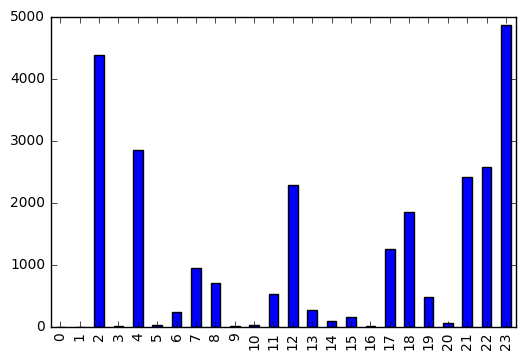

In [201]:
mask = Y['added_targets_dec'] > 0
targets_index_counts = np.zeros((len(TARGET_LABELS)))
for i, c in enumerate(TARGET_LABELS):
    s = (Y[mask][c] > 0).sum()
    targets_index_counts[i] = s

targets_index_counts = pd.Series(targets_index_counts)
targets_index_counts.plot.bar()

In [202]:
X.columns

Index([u'ncodpers', u'fecha_dato', u'fecha_alta', u'ind_empleado',
       u'pais_residencia', u'sexo', u'age', u'ind_nuevo', u'antiguedad',
       u'indrel',
       ...
       u'diff_targets_dec_13', u'diff_targets_dec_g0_13',
       u'diff_targets_dec_g1_13', u'diff_targets_dec_g2_13',
       u'diff_targets_dec_g3_13', u'diff_targets_dec_14',
       u'diff_targets_dec_g0_14', u'diff_targets_dec_g1_14',
       u'diff_targets_dec_g2_14', u'diff_targets_dec_g3_14'],
      dtype='object', length=157)

In [203]:
samples_masks_list = [
#     lambda x, y:  ~(x['targets_diff'].isin([0])) | ~(y['targets_diff'].isin([0])), 
#     lambda x, y:  (x['targets_diff'] > 0) | (y['targets_diff'] > 0), 
    lambda x, y:  (y['added_targets_dec'] > 0), 
]

features_masks_dict = {
    'fm_all': FEATURES_NAMES + FEATURES_NAMES + 
                PROCESSED_TARGETS(1) + 
                PROCESSED_TARGETS(2) + 
                PROCESSED_TARGETS(3) + 
                PROCESSED_TARGETS(4) + 
                DIFF_TARGETS(1, 2) + 
                DIFF_TARGETS(1, 3) + 
                DIFF_TARGETS(1, 4),
#     'fm0': features + TARGET_LABELS_FRQ.tolist(),
#     'fm1': ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'],
#     'fm1': TARGET_LABELS_FRQ_PREV,
#     'fm2': target_features,
#     'fm3': ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
#     'fm4': ['pais_residencia', 'sexo', 'age', 'renta', 'targets_logdiff', 'targets_logcount2_diff','targets_logcount2','targets_logcount1'],
#     'fm5': ['nomprov', 'ind_nuevo', 'renta', 'ind_actividad_cliente', 'canal_entrada'],
#     'fm6': TARGET_LABELS_FRQ,
}

In [204]:
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

def create_RF(input_shape, output_shape):        
    # https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
    return RandomForestClassifier(n_estimators=100, 
#                                   min_samples_split=100,
#                                   min_samples_leaf=25,
#                                   max_depth=10
                                  max_features=1.0, 
#                                   oob_score=True,
#                                   bootstrap=True,
                                  n_jobs=-1
                                 )

def create_ET(input_shape, output_shape):
    return ExtraTreesClassifier(n_estimators=100,
#                                   min_samples_leaf=25,
#                                   max_depth=10
                                  max_features=1.0, 
                                  oob_score=True,
                                  bootstrap=True,
                                  n_jobs=-1

                               )

def create_GB(input_shape, output_shape):
    return GradientBoostingClassifier(n_estimators=75)


def create_NN0(input_shape, output_shape):
        
    assert len(input_shape) == 2, "Input shape should be 2D"
    assert len(output_shape) == 2, "Input shape should be 2D"
    n_features = input_shape[1]
    output_dim = output_shape[1]
    
    def create_model(input_dim=n_features, output_dim=output_dim):
        model = Sequential()
        model.add(Dense(30, init='uniform', input_shape=(input_dim,), activation='relu'))
        model.add(Dropout(0.15))
#         model.add(Dense(output_dim, activation='sigmoid'))
        model.add(Dense(output_dim, activation='softmax'))
#         model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
        model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
        return model

    return KerasClassifier(build_fn=create_model, nb_epoch=200, batch_size=2000, verbose=0)
    

models_dict = {
    'rf': create_RF,
    'et': create_ET,
    'gb': create_GB,
#     'nn0': create_NN0
}

In [205]:
NP_TARGET_LABELS = np.array(TARGET_LABELS)
target_labels = NP_TARGET_LABELS

common_groups = [
    [2, 4, 7, 8, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23],
#     [2, 4],    
#     [2, 6, 7, 8],
#     [2, 18, 23, 12], 
#     [21, 22],
#     [2, 12, 18],
#     [2, 12, 23],
#     [2, 18, 23],
#     [18, 23, 21, 22],
#     [21, 23, 22, 4],
#     [3, 4], 
#     [22, 7, 8, 23],
#     [0, 1, 14, 15, 17]
]

common_groups += [[i] for i in [2, 4, 7, 8, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23]]



def flatten(array):
    out = []
    for item in array:
        out += item
    return out

others = list(set(range(24)) - set(flatten(common_groups)))

# for i, a in enumerate(zip(TARGET_LABELS2, TARGET_LABELS)):
#     print i, a
    
s = set({})
labels_masks_dict = {}
for i, g in enumerate(common_groups):
    print 'lm_%i' % i, " <=> ", g, "<==>", TARGET_LABELS2[g]
    labels_masks_dict['lm_%i' % i] = target_labels[g]
    s |= set(g)
    
# print 'lm_others', "<=>", others, "<==>", TARGET_LABELS2[others]
# labels_masks_dict['lm_others'] = target_labels[others]
# s |= set(others)

# assert len(s) == len(target_labels), "Sum is not equal 24, s=%i" % s
print labels_masks_dict

lm_0  <=>  [2, 4, 7, 8, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23] <==> ['Current Accounts' 'Payroll Account' 'particular Account'
 'particular Plus Account' 'Long-term deposits' 'e-account' 'Funds'
 'Pensions (plan fin)' 'Taxes' 'Credit Card' 'Securities' 'Payroll'
 'Pensions' 'Direct Debit']
lm_1  <=>  [2] <==> ['Current Accounts']
lm_2  <=>  [4] <==> ['Payroll Account']
lm_3  <=>  [7] <==> ['particular Account']
lm_4  <=>  [8] <==> ['particular Plus Account']
lm_5  <=>  [11] <==> ['Long-term deposits']
lm_6  <=>  [12] <==> ['e-account']
lm_7  <=>  [13] <==> ['Funds']
lm_8  <=>  [15] <==> ['Pensions (plan fin)']
lm_9  <=>  [17] <==> ['Taxes']
lm_10  <=>  [18] <==> ['Credit Card']
lm_11  <=>  [19] <==> ['Securities']
lm_12  <=>  [21] <==> ['Payroll']
lm_13  <=>  [22] <==> ['Pensions']
lm_14  <=>  [23] <==> ['Direct Debit']
{'lm_12': array(['ind_nomina_ult1'], 
      dtype='|S17'), 'lm_13': array(['ind_nom_pens_ult1'], 
      dtype='|S17'), 'lm_10': array(['ind_tjcr_fin_ult1'], 
      dty

In [206]:
# {model_name: [(samples_mask_code, features_mask_name, labels_mask_name), ...]}
models_pipelines = {
    'gb' : [(None, None, key) for key in labels_masks_dict if len(labels_masks_dict[key]) == 1],    
    'rf' : [(None, None, key) for key in labels_masks_dict if len(labels_masks_dict[key]) > 1],
    'et' : [(None, None, key) for key in labels_masks_dict if len(labels_masks_dict[key]) > 1],
}
models_pipelines

{'et': [(None, None, 'lm_0')],
 'gb': [(None, None, 'lm_12'),
  (None, None, 'lm_13'),
  (None, None, 'lm_10'),
  (None, None, 'lm_11'),
  (None, None, 'lm_14'),
  (None, None, 'lm_8'),
  (None, None, 'lm_9'),
  (None, None, 'lm_1'),
  (None, None, 'lm_2'),
  (None, None, 'lm_3'),
  (None, None, 'lm_4'),
  (None, None, 'lm_5'),
  (None, None, 'lm_6'),
  (None, None, 'lm_7')],
 'rf': [(None, None, 'lm_0')]}

In [207]:
from trainval import train_all, predict_all, probas_to_indices, score_estimators
from utils import map7_score0

In [208]:
ll = 140000
# ll = 1100

mask = (X.index.isin((X.index[:ll//3]))) | (X.index.isin((X.index[2*ll//3:])))

X1 = X[mask]
Y1 = Y[mask]
print X1.shape, Y1.shape

mask = X.index.isin(X.index[ll//3:2*ll//3])
X2 = X[mask]
Y2 = Y[mask]
print X2.shape, Y2.shape

(203333, 157) (203333, 76)
(46667, 157) (46667, 76)


In [209]:
# res = Y1[labels_masks_dict['lm_0']].apply(dummies_to_decimal, axis=1)
# res = pd.get_dummies(res)
# res.head()

In [210]:
from utils import dummies_to_decimal
from sklearn.preprocessing import StandardScaler


def prepare_to_fit(X_train, Y_train):    
    x_train = X_train.values
    x_train = StandardScaler().fit_transform(x_train)
    y_train = Y_train.apply(dummies_to_decimal, axis=1)
    y_train = pd.get_dummies(y_train)
    y_train = y_train.values    
    return x_train, y_train


def prepare_to_test(X_val, Y_val=None):
    x_val = X_val.values
    x_val = StandardScaler().fit_transform(x_val)
    if Y_val is not None:
        y_val = Y_val.apply(dummies_to_decimal, axis=1)
        y_val = pd.get_dummies(y_val)
        y_val = y_val.values 
    else:
        y_val = None
    return x_val, y_val


def probas_to_labels_probas(y_probas, class_indices, labels):
    l = len(labels)
    out = np.zeros((len(y_probas), l))
    i = 0
    for probas in y_probas:
        if np.sum(probas) > 0:
            pr = np.zeros((l,))
            for index, p in zip(class_indices, probas):
                dummies_str = decimal_to_dummies(index, l)
                pr += p * np.array([float(v) for v in dummies_str])
            out[i, :] = pr    
        i += 1
    return out
    

In [213]:
_kwargs = {
    'samples_masks_list': samples_masks_list, 
    'features_masks_dict': features_masks_dict, 
    'labels_masks_dict': labels_masks_dict, 
    'models_dict': models_dict,
    'labels': target_labels,
    'transform_proba_func': probas_to_indices,
#     'prepare_to_fit_func': prepare_to_fit,
#     'prepare_to_test_func': prepare_to_test,   
#     'probas_to_labels_probas_func': probas_to_labels_probas,
    'threshold': 0.15,
    'n_highest': 7,
    'mode': 'sum',
    'verbose': False,
    'models_pipelines': models_pipelines,
    'return_probas': True
}

In [214]:
estimators = train_all(X1, Y1, **_kwargs)

#print estimators

INFO:root:-- Train all --
INFO:root:-- Process : sample_mask=6112/203333, features_mask=fm_all, labels_mask=lm_12
INFO:root:--- Score : model='gb', fit accuracy : 0.909359
INFO:root:-- Process : sample_mask=6112/203333, features_mask=fm_all, labels_mask=lm_13
INFO:root:--- Score : model='gb', fit accuracy : 0.908050
INFO:root:-- Process : sample_mask=6112/203333, features_mask=fm_all, labels_mask=lm_10
INFO:root:--- Score : model='gb', fit accuracy : 0.947480
INFO:root:-- Process : sample_mask=6112/203333, features_mask=fm_all, labels_mask=lm_11
INFO:root:--- Score : model='gb', fit accuracy : 0.997709
INFO:root:-- Process : sample_mask=6112/203333, features_mask=fm_all, labels_mask=lm_14
INFO:root:--- Score : model='gb', fit accuracy : 0.880399
INFO:root:-- Process : sample_mask=6112/203333, features_mask=fm_all, labels_mask=lm_8
INFO:root:--- Score : model='gb', fit accuracy : 0.999673
INFO:root:-- Process : sample_mask=6112/203333, features_mask=fm_all, labels_mask=lm_9
INFO:root:--

In [215]:
accuracies = defaultdict(list)
for e in estimators:
    accuracies[e[0][2]].append(e[2])

mean_accuracy = {}
for key in accuracies:
    accuracy_list = accuracies[key]
    mean_accuracy[key] = sum(accuracy_list)/len(accuracy_list)
    
mean_accuracy

{'et': 0.99509162303664922,
 'gb': 0.96052262528047871,
 'rf': 0.99541884816753923}

In [216]:
_ = score_estimators(estimators, X2, Y2, **_kwargs)

INFO:root:-- Score : model=gb, features_mask=fm_all, labels_mask=lm_12 -> 0.98594295755
INFO:root:-- Score : model=gb, features_mask=fm_all, labels_mask=lm_13 -> 0.975485889387
INFO:root:-- Score : model=gb, features_mask=fm_all, labels_mask=lm_10 -> 0.976728737652
INFO:root:-- Score : model=gb, features_mask=fm_all, labels_mask=lm_11 -> 0.986028671224
INFO:root:-- Score : model=gb, features_mask=fm_all, labels_mask=lm_14 -> 0.963785972957
INFO:root:-- Score : model=gb, features_mask=fm_all, labels_mask=lm_8 -> 0.999978571582
INFO:root:-- Score : model=gb, features_mask=fm_all, labels_mask=lm_9 -> 0.999464289541
INFO:root:-- Score : model=et, features_mask=fm_all, labels_mask=lm_0 -> 0.501510703495
INFO:root:-- Score : model=rf, features_mask=fm_all, labels_mask=lm_0 -> 0.0476996592881
INFO:root:-- Score : model=gb, features_mask=fm_all, labels_mask=lm_1 -> 0.632609767073
INFO:root:-- Score : model=gb, features_mask=fm_all, labels_mask=lm_2 -> 0.996550024643
INFO:root:-- Score : model=

In [217]:
y_preds, Y_probas = predict_all(estimators, X2, **_kwargs)
#print y_preds[:5]

INFO:root:-- Predict all --


In [218]:
print y_preds[:5]
Y_probas.head()

[[2] [19, 17, 2, 23, 7, 18] [2, 23] [2] [17, 2, 23, 7]]


,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
447231,0.0,0.0,1.909359,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.000000
447222,0.0,0.0,2.904450,0.0,0.0,0.0,0.0,1.990510,0.0,0.0,...,0.0,0.0,0.0,2.98233,0.995419,2.98822,0.0,0.0,0.0,1.990510
446623,0.0,0.0,2.904450,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.995419
446621,0.0,0.0,1.909359,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.000000
446015,0.0,0.0,2.904450,0.0,0.0,0.0,0.0,0.995092,0.0,0.0,...,0.0,0.0,0.0,2.98233,0.000000,0.00000,0.0,0.0,0.0,1.990510


In [219]:
#labels_masks_dict['lm_0'], common_groups[0]

In [221]:
y_val = targets_str_to_indices(Y2[target_labels].values)
# y_val = targets_str_to_indices(Y2[labels_masks_dict['lm_0']].values, index_map=common_groups[0])
#print y_val[:100]
#print y_preds[:100]

In [222]:
#np.unique(y_preds)

In [223]:


logging.info("- Compute max map7 score")
map7_score(y_val, y_val, Y2[LAST_TARGET_LABELS].values)
# map7_score0(y_val, y_val)
logging.info("- Compute map7 score")
map7_score(y_val, y_preds, Y2[LAST_TARGET_LABELS].values)
# map7_score0(y_val, y_preds)

INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0295069320933
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0221204967584


0.022120496758356492


On columns lm_0=['ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1','ind_ctju_fin_ult1']

- Feature mask: all : 'fm6', 'fm4', 'fm5', 'fm2', 'fm3', 'fm0', 'fm1'
- threshold = 0.0

Model | Map@7 | Max Map@7 | Labels mask | Samples mask
--- | --- | --- | ---
et | 0.007074370518592629 | 0.0075787893947 | lm_0 | all 


In [ ]:
# print labels_masks_dict[estimators[0][0][1]]
# print estimators[0][1].classes_
# print estimators[0][1].n_classes_
# print estimators[0][1].n_features_
# print estimators[0][1].n_outputs_
# print estimators[0][1].estimators_

In [224]:
from utils import targets_to_labels, targets_indices_to_labels, remove_last_choice

In [226]:
limit = 25
count = 0

not_predicted_predicted = defaultdict(int)
for last_choice, targets, products, proba in zip(Y2[LAST_TARGET_LABELS].values, y_val, y_preds, Y_probas.values):
    added_products = remove_last_choice(targets, last_choice)
    predictions = remove_last_choice(products, last_choice)
#     print "---", count, last_choice
#     print targets, '->', added_products
#     print products, '->', predictions
#     if count == 3:
#         break
    
    if len(added_products) == 0:
        continue
        
    if len(set(added_products) & set(predictions)) > 0:
#         print "Predicted : ", added_products, predictions
#         print set(added_products) & set(predictions)
        continue

    count += 1
    if count < limit:
        print "--- Count = ", count
        print targets_indices_to_labels(added_products, TARGET_LABELS2)#, targets_indices_to_labels(targets, TARGET_LABELS2)
        print targets_indices_to_labels(predictions, TARGET_LABELS2)#, targets_indices_to_labels(products, TARGET_LABELS2)#, proba
    
    for p in added_products:
        not_predicted_predicted[TARGET_LABELS2[p]] += 1
    

--- Count =  1
['particular Account']
['Credit Card', 'Payroll', 'Pensions']
--- Count =  2
['particular Account', 'Home Account']
['Current Accounts', 'Direct Debit']
--- Count =  3
['Credit Card']
[]
--- Count =  4
['Credit Card']
['Direct Debit']
--- Count =  5
['Payroll', 'Pensions']
['Credit Card']
--- Count =  6
['e-account']
['Current Accounts']
--- Count =  7
['Long-term deposits']
['Direct Debit', 'Credit Card']
--- Count =  8
['e-account']
['Direct Debit']
--- Count =  9
['Payroll', 'Pensions']
[]
--- Count =  10
['particular Account']
['Payroll', 'Pensions']
--- Count =  11
['Credit Card']
['Direct Debit']
--- Count =  12
['Credit Card']
['Direct Debit']
--- Count =  13
['Taxes']
[]
--- Count =  14
['Taxes']
['Credit Card', 'Current Accounts']
--- Count =  15
['Credit Card']
[]
--- Count =  16
['e-account']
['Direct Debit']
--- Count =  17
['Payroll', 'Pensions']
['Current Accounts']
--- Count =  18
['Current Accounts']
['Payroll Account', 'Payroll', 'Direct Debit']
--- Coun

In [227]:
print not_predicted_predicted, y_val.shape[0]

defaultdict(<type 'int'>, {'Securities': 9, 'Direct Debit': 8, 'particular Account': 17, 'particular Plus Account': 12, 'e-account': 61, 'Payroll': 55, 'Pensions': 59, 'Taxes': 8, 'Payroll Account': 33, 'Long-term deposits': 3, 'Credit Card': 68, 'Mas particular Account': 5, 'Funds': 3, 'Home Account': 1, 'Current Accounts': 5, 'Junior Account': 2}) 46667


In [ ]:
#print y_probas[:10, target_groups[0]]
#print Y[np.array(TARGET_LABELS)[target_groups[0]]].head(10)

### Run KFold Cross-validation 

In [230]:
from trainval import cross_val_score0, cross_val_score

In [ ]:
# Unitary run
nb_folds = 5
results = cross_val_score((X, Y, Y[LAST_TARGET_LABELS].values), nb_folds=nb_folds, **_kwargs)

print "Cross-Validation \n %i | %f | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), np.median(results), results.max(), results.std())


INFO:root:- Cross validation : 
INFO:root:

		-- Fold : 1 / 5

INFO:root:-- Train all --
INFO:root:-- Process : sample_mask=5605/200000, features_mask=fm_all, labels_mask=lm_12
INFO:root:--- Score : model='gb', fit accuracy : 0.905977
INFO:root:-- Process : sample_mask=5605/200000, features_mask=fm_all, labels_mask=lm_13
INFO:root:--- Score : model='gb', fit accuracy : 0.903836
INFO:root:-- Process : sample_mask=5605/200000, features_mask=fm_all, labels_mask=lm_10
INFO:root:--- Score : model='gb', fit accuracy : 0.949153
INFO:root:-- Process : sample_mask=5605/200000, features_mask=fm_all, labels_mask=lm_11
INFO:root:--- Score : model='gb', fit accuracy : 0.997859
INFO:root:-- Process : sample_mask=5605/200000, features_mask=fm_all, labels_mask=lm_14
INFO:root:--- Score : model='gb', fit accuracy : 0.876717
INFO:root:-- Process : sample_mask=5605/200000, features_mask=fm_all, labels_mask=lm_8
INFO:root:--- Score : model='gb', fit accuracy : 1.000000
INFO:root:-- Process : sample_mask=5


### 201505 -> 201605 

Cross-Validation 
 5 | 0.014585 | 0.018385 | 0.019147 | 0.022227 | 0.00294 

Compute cross-validation across several months

In [ ]:
nb_folds = 3
yms = [201504, 201505]
#yms = [201505]

for ym in yms:
    logging.info("\n-------------------------")
    logging.info("- Process month : %s" % ym)
    logging.info("-------------------------\n")
    
    ym1 = ym + 100    
    df1 = train_df if months_ym_map[ym] in train_months else val_df
    df2 = train_df if months_ym_map[ym1] in train_months else val_df
    X, Y, clients_last_choice = get_XY(ym, df1, ym1, df2) 
    results = cross_val_score2((X, Y, clients_last_choice[LC_TARGET_LABELS].values), 
                                profiles=profiles,
                                nb_folds=nb_folds)
    print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

## Train model for predictions

In [ ]:
current_month = 201505
next_year_month = current_month + 100

df1 = train_df
#df1 = val_df
df2 = train_df #if months_ym_map[next_year_month] in train_months else val_df
#df2 = val_df

X, Y, clients_last_choice = get_XY(current_month, df1, next_year_month, df2, months_ym_map)

In [ ]:
estimators = train_all(X, Y, **_kwargs)

In [ ]:
y_preds, Y_probas = predict_all(estimators, X, **_kwargs)

Check score on the data 2016/05

In [ ]:
logging.info("- Compute map7 score")
print map7_score(y_val, y_preds, clients_last_choice[LC_TARGET_LABELS].values)
logging.info("- Compute max map7 score")
print map7_score(y_val, y_val, clients_last_choice[LC_TARGET_LABELS].values)

## Prediction for 2016/06

In [ ]:
from dataset import load_train_test

In [ ]:
full_train_df, test_df = load_train_test([201506])

In [ ]:
full_train_df.head()

In [ ]:
test_df.head()

In [ ]:
months_ym_map = {}
months = list(set(full_train_df['fecha_dato'].unique()) | set(test_df['fecha_dato'].unique()))
for m in months:
    months_ym_map[to_yearmonth(m)] = m
    
full_train_months = full_train_df['fecha_dato'].unique()
test_months = test_df['fecha_dato'].unique()

In [ ]:
current_month = 201506
next_year_month = current_month + 100

df1 = full_train_df
df2 = test_df
X, _, clients_last_choice = get_XY(current_month, df1, next_year_month, df2, months_ym_map)

In [ ]:
print X.shape, test_df.shape

In [ ]:
X.head(10)

In [ ]:
clients_last_choice.head(10)

In [ ]:
def get_submission(predicted_added_products, clients, clc, target_labels):
    added_products_col = []
    count = 0 
    for products, last_choice in zip(predicted_added_products, clc):
        predictions = remove_last_choice(products, last_choice)
        added_products_col.append(' '.join([target_labels[i] for i in predictions]))
        count+=1
        if count % 100000 == 0:
            logging.info("Elapsed : %i", count)
            
    out = pd.DataFrame(data={'ncodpers': clients, 'added_products': added_products_col}, columns=['ncodpers', 'added_products'])
    return out

In [ ]:
y_preds, Y_probas = predict_all(estimators, X, **_kwargs)

logging.info("- Get submission dataframe:")
clients = X['ncodpers'].values
#submission = get_submission(y_preds, clients, clients_last_choice[LC_TARGET_LABELS].values, TARGET_LABELS)

In [ ]:
submission = get_submission(y_preds, clients, clients_last_choice[LC_TARGET_LABELS].values, TARGET_LABELS)

In [ ]:
print submission.shape
submission.head()

In [ ]:
selected_estimators = []
for e in estimators:
    # estimators = [([features_mask_name, labels_mask_name, model_name], estimator_object, accuracy), ...]
    features_mask_name, labels_mask_name, model_name = e[0]
#     print features_mask_name, labels_mask_name, model_name
    if set(features_masks_dict[features_mask_name]).issubset(test_df.columns):
#         print "Append the estimator"
        selected_estimators.append(e)

In [ ]:
submission_clients = set(submission['ncodpers'].unique())
test_clients = set(test_df['ncodpers'].unique())
if submission_clients != test_clients:
    missing_clients = list(test_clients - submission_clients)
    missing_clients_mask = test_df['ncodpers'].isin(missing_clients)
    
    X1 = test_df[missing_clients_mask]
        
    y_preds, Y_probas = predict_all(selected_estimators, X1, **_kwargs)    
    submission2 = get_submission(y_preds, missing_clients, X1[LC_TARGET_LABELS].values, TARGET_LABELS)
    
#     submission = pd.concat([submission, submission2])

In [ ]:
submission2 = get_submission(y_preds, missing_clients, X1[LC_TARGET_LABELS].values, TARGET_LABELS)
#submission = pd.concat([submission, submission2])

In [ ]:
print submission2.shape
submission2.head()

Get submission DataFrame and write csv file

In [ ]:
print submission.shape
submission.head()

In [ ]:
from datetime import datetime
import csv

logging.info('- Generate submission')
submission_file = '../results/submission_' + \
                  str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + \
                  '.csv'

submission.to_csv(submission_file, index=False, index_label=False)

In [ ]:
with open('../results/submission_2016-11-17-16-37.csv', 'r') as r:
    print r.readline()
    print r.readline()
    print r.readline()
    print r.readline()
    print r.readline()
    